In [3]:
import tensorflow as tf
import os
import random
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt
import PIL
import pathlib
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, UpSampling2D, SpatialDropout2D,concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.models import load_model
from keras import layers
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models, regularizers
from keras.utils import to_categorical
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy, F1Score
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.layers import Rescaling
from sklearn.model_selection import train_test_split

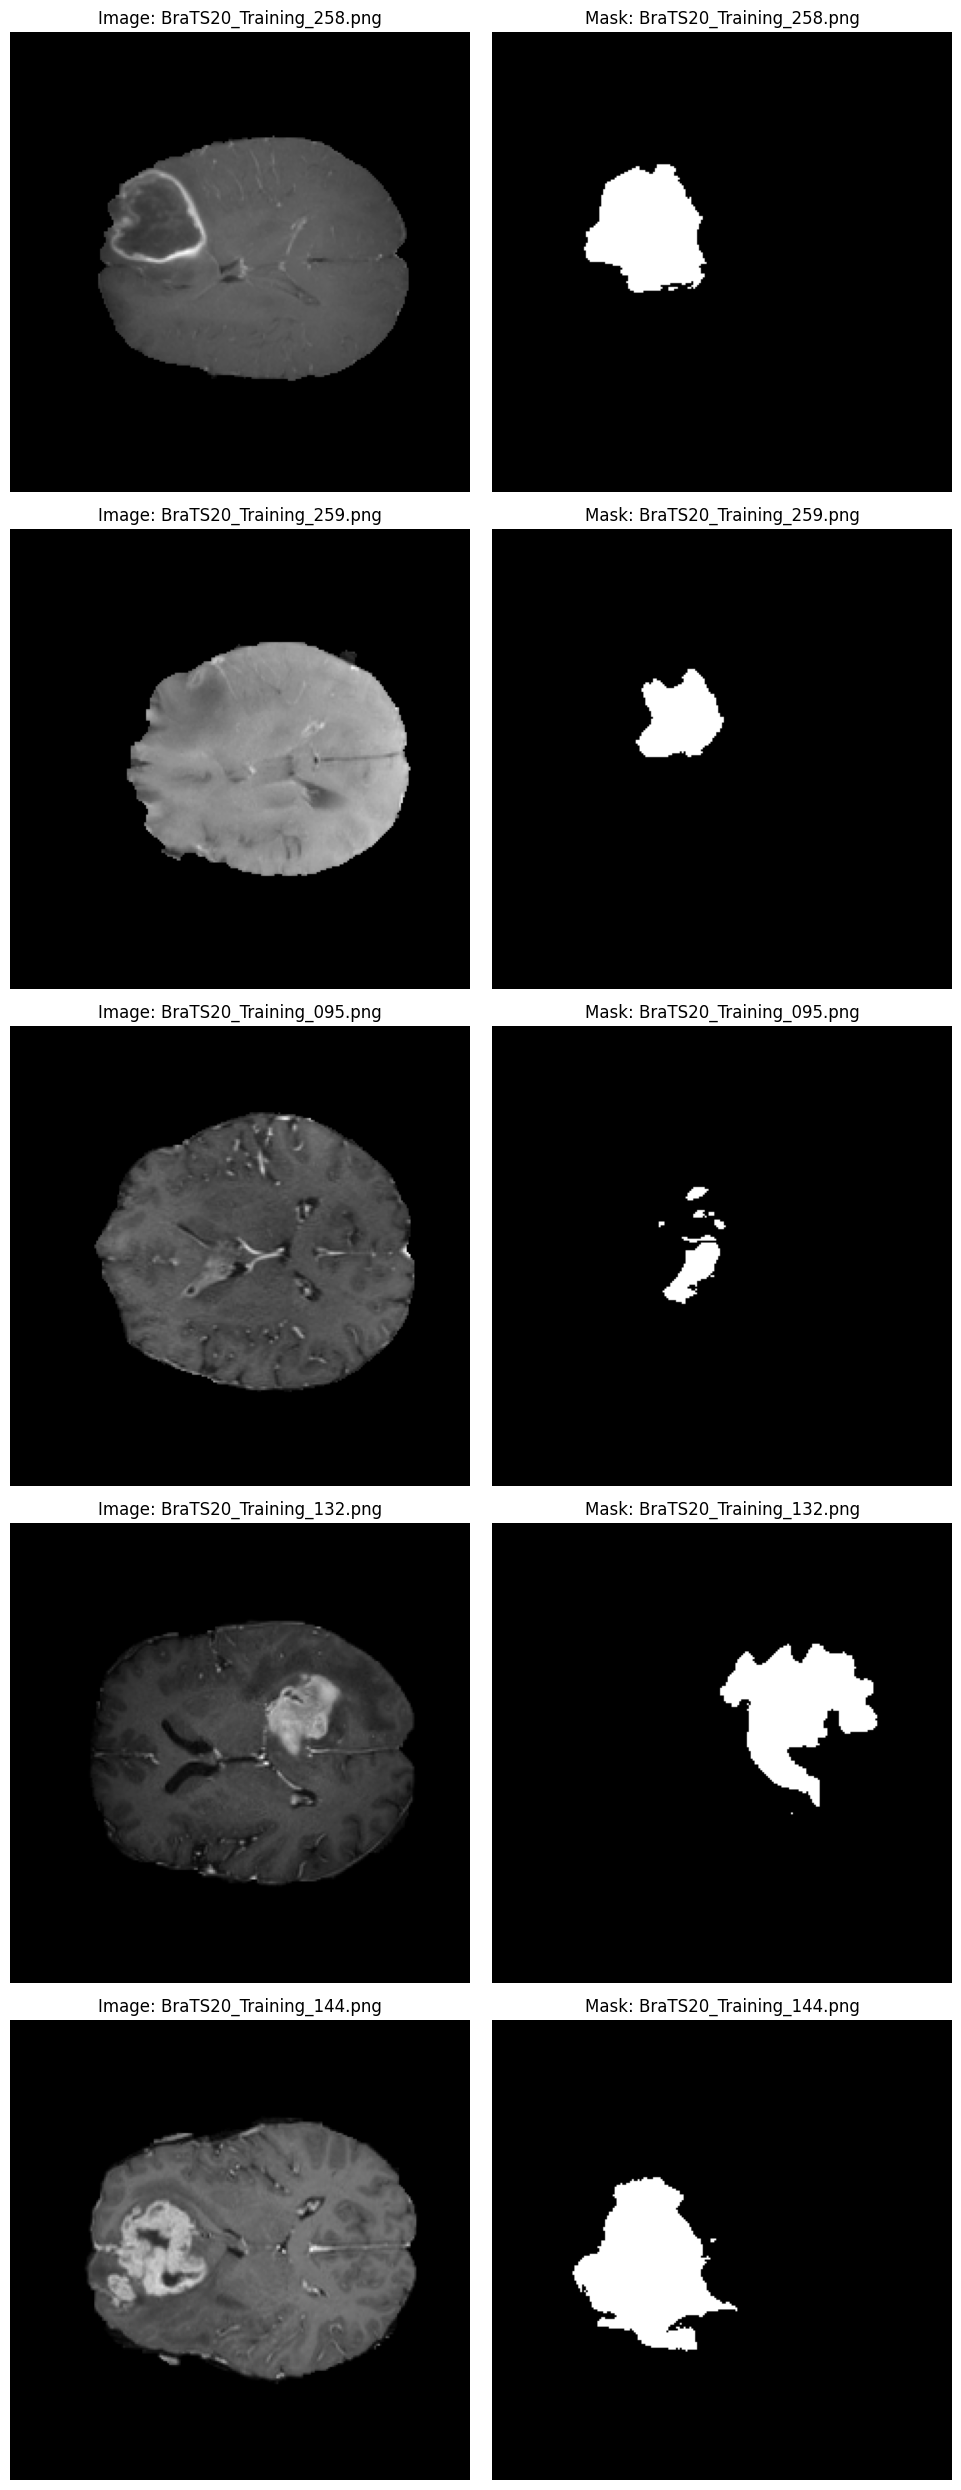

In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define dataset paths
image_dir = "/kaggle/input/brain-tumor-segmentation/images"
label_dir = "/kaggle/input/brain-tumor-segmentation/masks"

# Get a few sample files
sample_files = os.listdir(image_dir)[:5]  # Change number to see more images

# Plot images and masks
fig, axes = plt.subplots(len(sample_files), 2, figsize=(10, 5 * len(sample_files)))

for i, file in enumerate(sample_files):
    image_path = os.path.join(image_dir, file)
    label_path = os.path.join(label_dir, file)

    # Read image and mask
    image = cv2.imread(image_path)  # Read in BGR format
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    mask = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)

    # Display image
    axes[i, 0].imshow(image)
    axes[i, 0].set_title(f"Image: {file}")
    axes[i, 0].axis("off")

    # Display mask
    axes[i, 1].imshow(mask, cmap="gray")
    axes[i, 1].set_title(f"Mask: {file}")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()


In [5]:
import os
import cv2
import numpy as np
import tensorflow as tf
import albumentations as A
from sklearn.model_selection import train_test_split

# Define dataset paths
image_dir = "/kaggle/input/brain-tumor-segmentation/images"
label_dir = "/kaggle/input/brain-tumor-segmentation/masks"

# Define target size for resizing
TARGET_SIZE = (160, 160)  

# Define augmentation pipeline using Albumentations
transform = A.Compose([
    A.Resize(TARGET_SIZE[0], TARGET_SIZE[1], interpolation=cv2.INTER_LINEAR),  # Resize images
    A.HorizontalFlip(p=0.5),  # Random horizontal flip
    A.RandomBrightnessContrast(p=0.2),  # Adjust brightness and contrast
    A.Rotate(limit=20, p=0.5),  # Random rotation
])

# Function to load and preprocess images
def load_image(image_path, label_path):
    # Read images in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)

    # Ensure valid images
    if image is None or mask is None:
        raise RuntimeError(f"Failed to load image or mask: {image_path}, {label_path}")

    # Expand dimensions to match (H, W, 1)
    image = np.expand_dims(image, axis=-1)
    mask = np.expand_dims(mask, axis=-1)

    # Apply augmentation
    augmented = transform(image=image, mask=mask)
    image, mask = augmented["image"], augmented["mask"]

    # Normalize pixel values to [0, 1]
    image = image.astype(np.float32) / 255.0
    mask = mask.astype(np.float32) / 255.0  # Ensure mask is also normalized

    return image, mask

# Load all file names
image_files = os.listdir(image_dir)

# Split into train (65%), validation (20%), and test (15%)
train_files, temp_files = train_test_split(image_files, test_size=0.35, random_state=42)
val_files, test_files = train_test_split(temp_files, test_size=15/35, random_state=42)

print(f"Train size: {len(train_files)}, Validation size: {len(val_files)}, Test size: {len(test_files)}")

# Dataset Generator Function
def data_generator(file_list):
    for file in file_list:
        image_path = os.path.join(image_dir, file)
        label_path = os.path.join(label_dir, file)
        yield load_image(image_path, label_path)

# Convert to TensorFlow Dataset
def create_tf_dataset(file_list):
    dataset = tf.data.Dataset.from_generator(
        lambda: data_generator(file_list),
        output_signature=(
            tf.TensorSpec(shape=(160, 160, 1), dtype=tf.float32),  # Image
            tf.TensorSpec(shape=(160, 160, 1), dtype=tf.float32)   # Mask
        )
    )
    return dataset

# Create datasets
train_dataset = create_tf_dataset(train_files)
val_dataset = create_tf_dataset(val_files)
test_dataset = create_tf_dataset(test_files)

# Shuffle, batch, and prefetch
BATCH_SIZE = 16
train_dataset = train_dataset.shuffle(100).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Test dataset
for image_batch, mask_batch in train_dataset.take(1):
    print(f"Image batch shape: {image_batch.shape}, Mask batch shape: {mask_batch.shape}")


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Train size: 204, Validation size: 62, Test size: 48
Image batch shape: (16, 160, 160, 1), Mask batch shape: (16, 160, 160, 1)


In [6]:
import keras
# or from tensorflow import keras

keras.backend.set_image_data_format('channels_last')

!pip install segmentation-models
os.environ['SM_FRAMEWORK'] = 'tf.keras'  # Set to TensorFlow framework
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [15]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model

# Define U-Net model
def unet_model(input_size=(160, 160, 1)):
    inputs = Input(input_size)

    # Encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottleneck
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)

    # Decoder
    up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5)
    up6 = concatenate([up6, conv4])
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up7, conv3])
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
    up8 = concatenate([up8, conv2])
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
    up9 = concatenate([up9, conv1])
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs, outputs)
    return model

# Compile the model
model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 160, 160, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 160, 160, 64)   │            640 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 160, 160, 64)   │         36,928 │ conv2d_11[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 80, 80, 64)     │              0 │ conv2d_12[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 80, 80, 128)    │         73,856 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 80, 80, 128)    │        147,584 │ conv2d_13[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 40, 40, 128)    │              0 │ conv2d_14[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)        │ (None, 40, 40, 256)    │        295,168 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_16 (Conv2D)        │ (None, 40, 40, 256)    │        590,080 │ conv2d_15[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 20, 20, 256)    │              0 │ conv2d_16[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_17 (Conv2D)        │ (None, 20, 20, 512)    │      1,180,160 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_18 (Conv2D)        │ (None, 20, 20, 512)    │      2,359,808 │ conv2d_17[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 10, 10, 512)    │              0 │ conv2d_18[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 10, 10, 1024)   │      4,719,616 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 10, 10, 1024)   │      9,438,208 │ conv2d_19[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_1        │ (None, 20, 20, 512)    │      2,097,664 │ conv2d_20[0][0]        │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1        

 Total params: 31,030,593 (118.37 MB)

 Trainable params: 31,030,593 (118.37 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7
)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20,restore_best_weights=True)

In [17]:
history = model.fit(
    train_dataset,  # Your prepared TensorFlow dataset for training
    validation_data=val_dataset,  # Validation dataset
    epochs=100,
    batch_size=32,  # Ensure this is compatible with how your dataset is batched
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/100
     13/Unknown 90s 3s/step - accuracy: 0.9286 - loss: 0.9440   

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


13/13 ━━━━━━━━━━━━━━━━━━━━ 121s 6s/step - accuracy: 0.9305 - loss: 0.9387 - val_accuracy: 0.9662 - val_loss: 0.4645 - learning_rate: 0.0010
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 385ms/step - accuracy: 0.9700 - loss: 0.3149 - val_accuracy: 0.9662 - val_loss: 0.1294 - learning_rate: 0.0010
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 382ms/step - accuracy: 0.9661 - loss: 0.1203 - val_accuracy: 0.9662 - val_loss: 0.1110 - learning_rate: 0.0010
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 376ms/step - accuracy: 0.9690 - loss: 0.1121 - val_accuracy: 0.9663 - val_loss: 0.1113 - learning_rate: 0.0010
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 384ms/step - accuracy: 0.9674 - loss: 0.1106 - val_accuracy: 0.9663 - val_loss: 0.1098 - learning_rate: 0.0010
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 384ms/step - accuracy: 0.9668 - loss: 0.1059 - val_accuracy: 0.9662 - val_loss: 0.1054 - learning_rate: 0.0010
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 376ms/step - accuracy: 0.9675 - loss: 0.1067 - val_ac

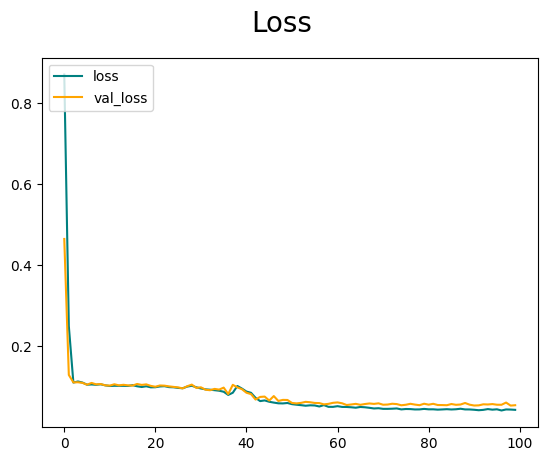

In [19]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [21]:
# Evaluate the model on the test dataset
test_loss, test_iou = model.evaluate(test_dataset)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test IoU Score: {test_iou:.4f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9801 - loss: 0.0503
Test Loss: 0.0495
Test IoU Score: 0.9807


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


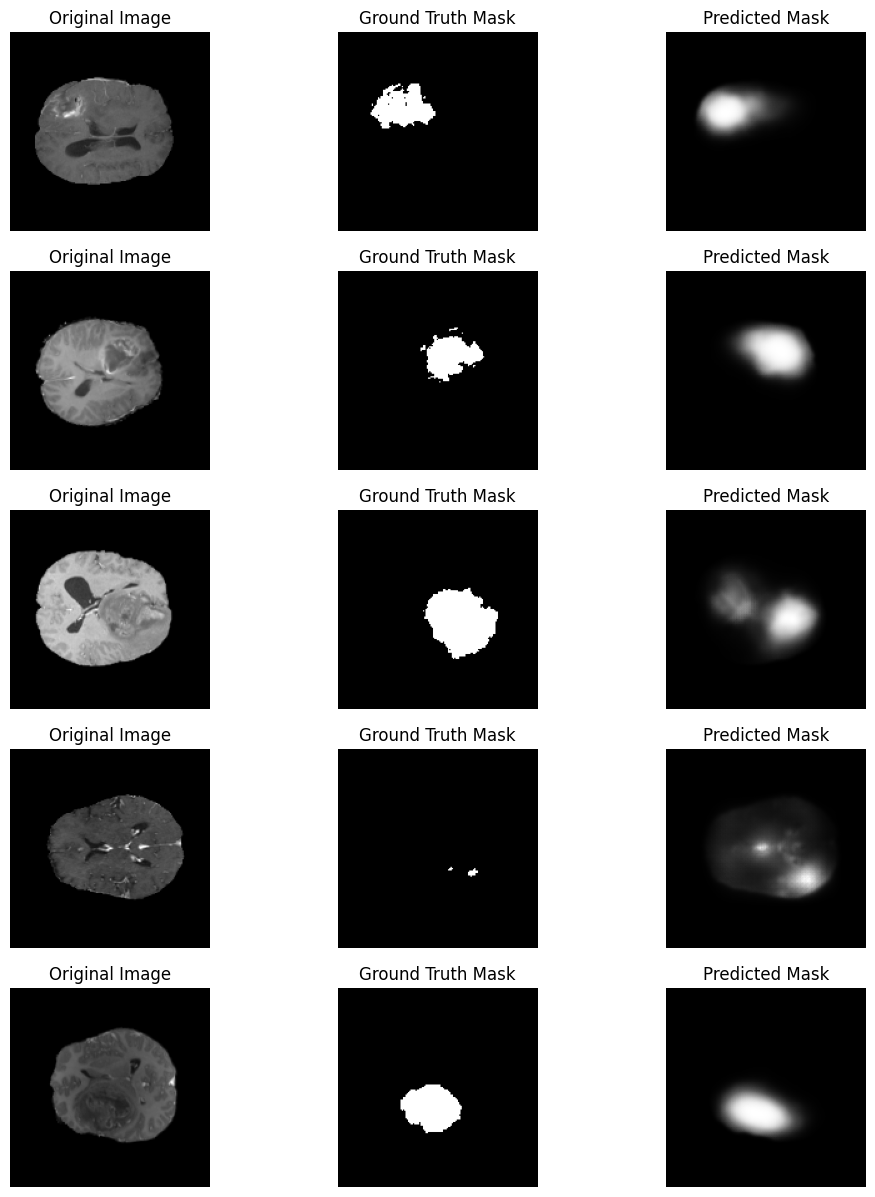

In [24]:
import matplotlib.pyplot as plt

# Function to visualize predictions
def visualize_predictions(model, dataset, num_samples=5):
    sample_images, sample_masks = next(iter(dataset.take(1)))
    predicted_masks = model.predict(sample_images)

    plt.figure(figsize=(12, num_samples * 3))

    for i in range(num_samples):
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(sample_images[i, :, :, 0], cmap="gray")
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(sample_masks[i, :, :, 0], cmap="gray")
        plt.title("Ground Truth Mask")
        plt.axis("off")

        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(predicted_masks[i, :, :, 0], cmap="gray")
        plt.title("Predicted Mask")
        plt.axis("off")

    plt.show()

# Run visualization
visualize_predictions(model, test_dataset)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


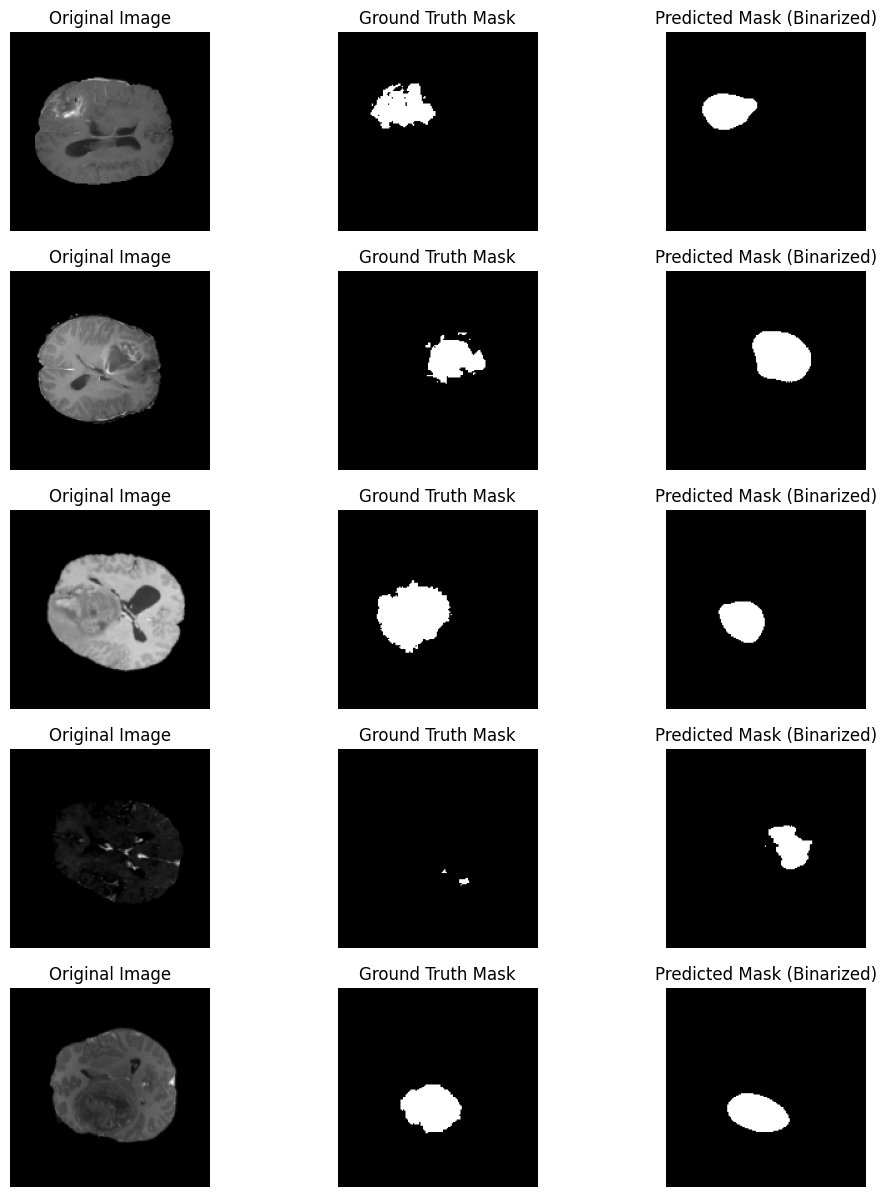

In [26]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_predictions(model, dataset, num_samples=5, threshold=0.5):
    test_images, test_masks = next(iter(dataset.take(1)))
    predicted_masks = model.predict(test_images)

    # Apply threshold to convert probabilities into binary masks
    predicted_masks = (predicted_masks > threshold).astype(np.uint8)

    plt.figure(figsize=(12, num_samples * 3))
    for i in range(num_samples):
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(test_images[i, :, :, 0], cmap="gray")
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(test_masks[i, :, :, 0], cmap="gray")
        plt.title("Ground Truth Mask")
        plt.axis("off")

        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(predicted_masks[i, :, :, 0], cmap="gray")
        plt.title("Predicted Mask (Binarized)")
        plt.axis("off")

    plt.show()

# Run visualization
visualize_predictions(model, test_dataset)


In [28]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

def load_and_preprocess_image(image_path, target_size=(160, 160)):
    # Load the image
    img = image.load_img(image_path, color_mode="grayscale", target_size=target_size)
    img_array = image.img_to_array(img)

    # Normalize the image (assuming your model expects normalized input)
    img_array = img_array / 255.0  

    # Expand dimensions to match model input shape (batch_size, height, width, channels)
    img_array = np.expand_dims(img_array, axis=0)
    
    return img_array

def test_image_from_path(model, image_path, threshold=0.5):
    # Load and preprocess the image
    sample_image = load_and_preprocess_image(image_path, target_size=(160, 160))

    # Predict the mask
    predicted_mask = model.predict(sample_image)[0, :, :, 0]

    # Binarize the mask
    predicted_mask = (predicted_mask > threshold).astype(np.uint8)

    # Plot results
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(sample_image[0, :, :, 0], cmap="gray")
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(predicted_mask, cmap="gray")
    plt.title("Predicted Mask (Binarized)")
    plt.axis("off")

    plt.show()

# Example usage: Change the image path to test a different image
image_path = "/kaggle/input/brain-tumors-dataset/Data/Tumor/glioma_tumor/G_101_BR_.jpg"  # Change this path
test_image_from_path(model, image_path)


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/brain-tumors-dataset/Data/Tumor/glioma_tumor/G_101_BR_.jpg'

In [29]:
model.save("brain_tumor_segmentation_model.h5")
